In [50]:
from Utils.preprocessing import *
from Utils.customPipelines import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.linear_model import Lasso
from sklearn import tree
from six import StringIO

from IPython.display import Image
import pydotplus
import graphviz

import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

RANDOM_STATE = 2024

# Webscraping Portion

In [2]:
# Read prof's sample data to view format & data science roles
sample_data_a = pd.read_csv("Data//jobs_in_data.csv")
sample_data_b = pd.read_csv("Data//QF632_Project_2_b.csv")
sample_data_c = pd.read_csv("Data//QF632_Project_2_c.csv")
sample_data_d = pd.read_csv("Data//Glassdoor_Salary_Cleaned_Version.csv")

In [3]:
base_url = "https://h1bdata.info/index.php?em=&job=data+scientist&city=&year=all+years"
roles = ["data scientist", "data analyst", "data storyteller", "data insights", "research scientist", "business data analyst",
        "data analytics", "data engineer", "machine learning", "ml engineer", "ai architect"]

all_df = pd.DataFrame()
for role in roles:
    job = "+".join(role.split(" "))
    url = base_url + "/index.php?em=&job=" + job + "&city=&year=all+years"
    try: 
        dfs_base = pd.read_html(url)
    except: 
        continue
    
    # to include all other variations, add a '&'
    url = base_url + "/index.php?em=&job=" + job + "+&&city=&year=all+years"
    
    try:
        dfs_var = pd.read_html(url)
    except:
        continue
    
    temp_df = pd.concat([dfs_base[0], dfs_var[0]])
    temp_df["TYPE"] = role
    
    all_df = pd.concat([all_df, temp_df])

print(all_df.shape)
all_df.sample(5)

(80866, 8)


,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,Unnamed: 6,TYPE
7487,THE HONEST COMPANY,DATA ENGINEER,102000,"LOS ANGELES, CA",03/07/2018,09/02/2018,NaN,data engineer
1757,INTEL CORPORATION,DATA SCIENTIST,72259,"AUSTIN, TX",05/23/2022,05/26/2022,NaN,data scientist
4235,AMAZON WEB SERVICES INC,DATA SCIENTIST II,169000,"SEATTLE, WA",09/15/2022,01/31/2023,NaN,data scientist
2887,PRO-TEK CONSULTING,DATA ENGINEER,80000,"NEW YORK, NY",03/06/2019,09/02/2019,NaN,data engineer
4869,AMAZONCOM SERVICES LLC,DATA SCIENTIST III,180000,"NEW YORK, NY",12/14/2021,12/19/2021,NaN,data scientist


# Data Analysis

In [4]:
all_df["START DATE"] = pd.to_datetime(all_df["START DATE"], errors='coerce')
all_df["SUBMIT DATE"] = pd.to_datetime(all_df["SUBMIT DATE"], errors='coerce')
all_df = all_df.drop_duplicates()

# Remove all non-numeric "y" values
all_df2 = all_df[pd.to_numeric(all_df['BASE SALARY'], errors='coerce').notnull()].copy()

# all_df2 = all_df.dropna(subset = ["BASE SALARY"]).copy()
all_df2 = all_df2.drop(columns=["Unnamed: 6"]).reset_index(drop=True)
all_df2["YEAR"] = pd.DatetimeIndex(all_df2['START DATE']).year

# To get state, first remove all symbols, then take the last two letters
regex = re.compile('[^a-zA-Z]')
all_df2['STATE'] = all_df2.LOCATION.apply(lambda x:regex.sub('', x)[-2:])
all_df2 = all_df2.rename(columns={"BASE SALARY":"y"})
all_df2["y"] =  pd.to_numeric(all_df2["y"]) / 1000

print(all_df2.shape)
all_df2.sample(5)

(74810, 9)


,EMPLOYER,JOB TITLE,y,LOCATION,SUBMIT DATE,START DATE,TYPE,YEAR,STATE
5910,ACE AMERICAN INSURANCE COMPANY,DATA SCIENTIST,97.343,"JERSEY CITY, NJ",2022-03-29,2022-09-20,data scientist,2022,NJ
16423,WAYMO LLC,DATA SCIENTIST,175.000,"SAN FRANCISCO, CA",2023-02-27,2023-08-18,data scientist,2023,CA
25631,THE ARTHUR PAGE SOCIETY,DATA ANALYST,63.499,"NEW YORK, NY",2021-05-06,2021-06-01,data analyst,2021,NY
58701,SAGE IT INC,DATA ENGINEER,101.754,"NORTH BRUNSWICK, NJ",2022-06-17,2022-06-27,data engineer,2022,NJ
15202,UBER TECHNOLOGIES INC,DATA SCIENTIST,158.500,"MOUNT VERNON, NY",2022-05-04,2022-05-11,data scientist,2022,NY


## 1. Numerical Features

## 2. Categorical features

### 2a. Analysis of job demand by job function

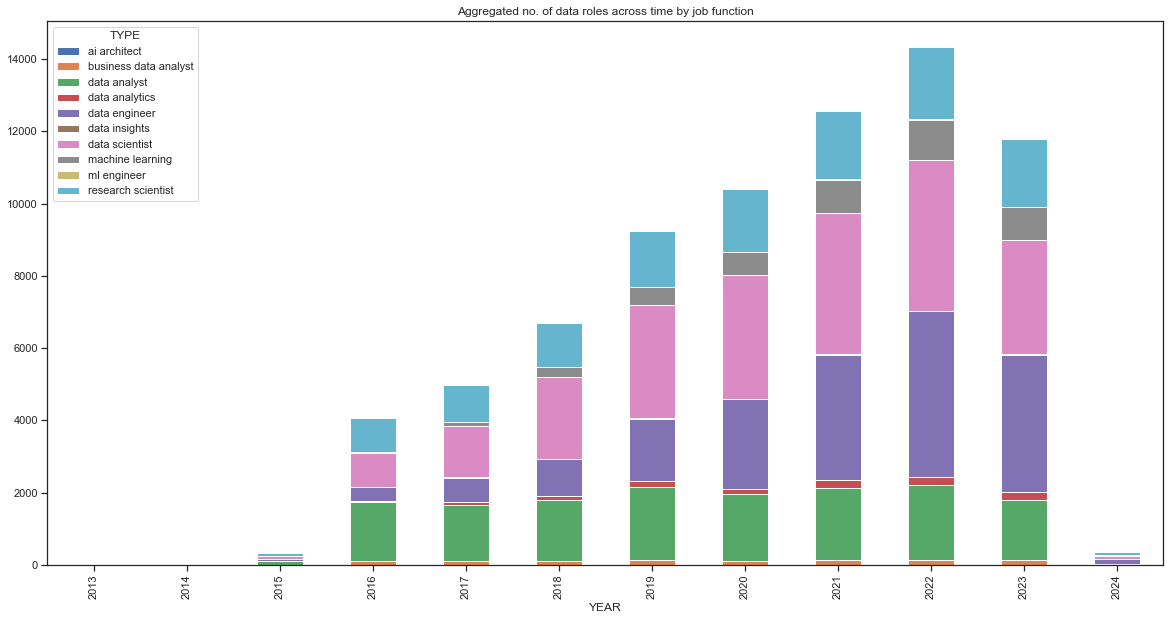

In [5]:
category = "TYPE"

df_plt = all_df2[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.bar(figsize=(20, 10), stacked=True, title="Aggregated no. of data roles across time by job function")

data scientist        22637
data engineer         18283
data analyst          14573
research scientist    12404
others                 6913
Name: TYPE, dtype: int64


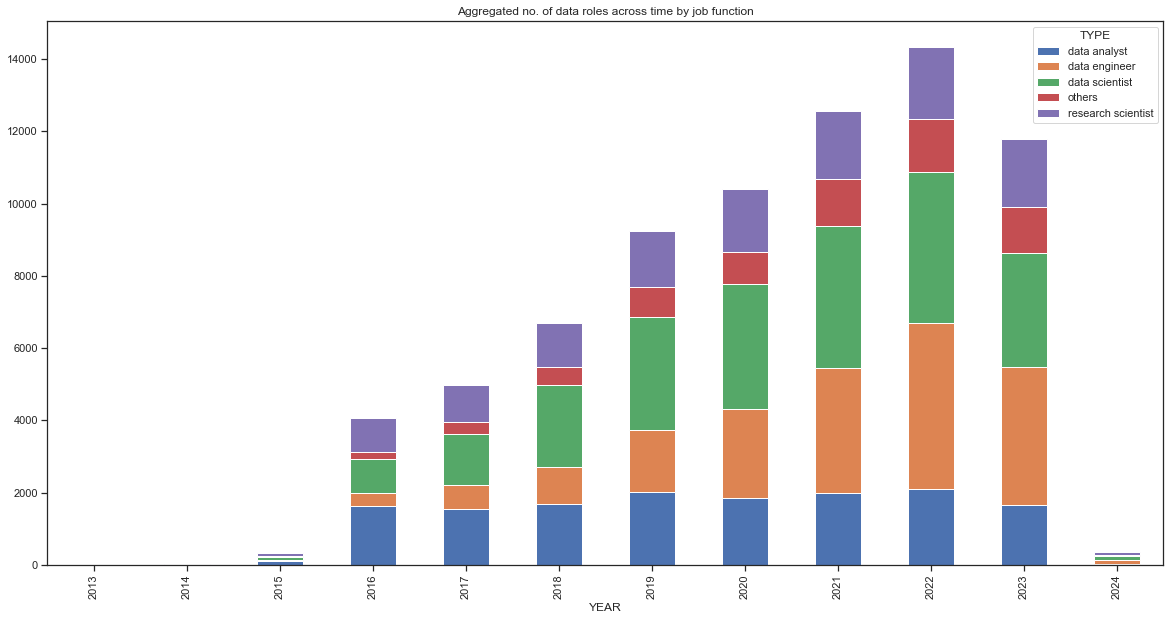

In [6]:
df_type_agg = all_df2.copy()
core_cat = ["research scientist", "data scientist", "data analyst", "data engineer"]
df_type_agg['TYPE'].mask(~df_type_agg["TYPE"].isin(core_cat) ,'others', inplace=True)

df_plt = df_type_agg[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
print(df_type_agg["TYPE"].value_counts())
ax = df_plt.plot.bar(figsize=(20, 10), stacked=True, title="Aggregated no. of data roles across time by job function")

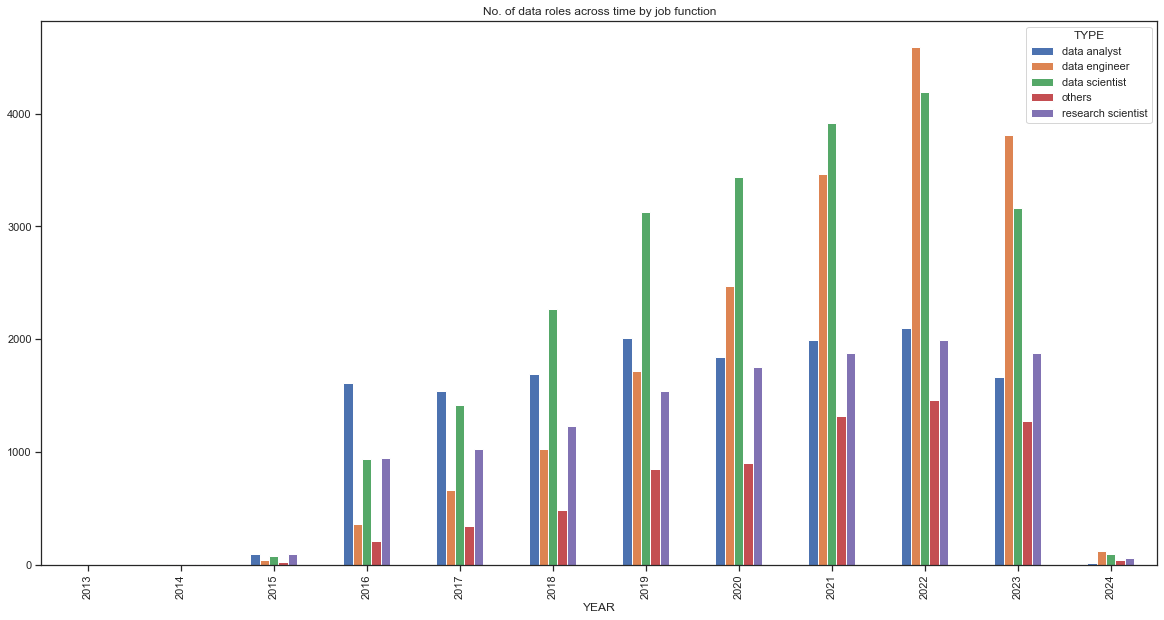

In [7]:
ax = df_plt.plot.bar(figsize=(20, 10), title="No. of data roles across time by job function")

Job functions not of major classes (data analyst, data engineer, data scientist, research scientist) can form 1 class called "others".
From the graphs above, we can see that the number of data roles have been increasing across time, peaking in 2022. Further breakdown of the data roles into the major classes shows that demand for data engineers have seen the most growth across time, and remains to be of the highest demand today. Data scientists and research scientists have also seen a general increase in demand, while data analysts have seen fluctuations in demand across years.

### 2b. Analysis of wage by job function

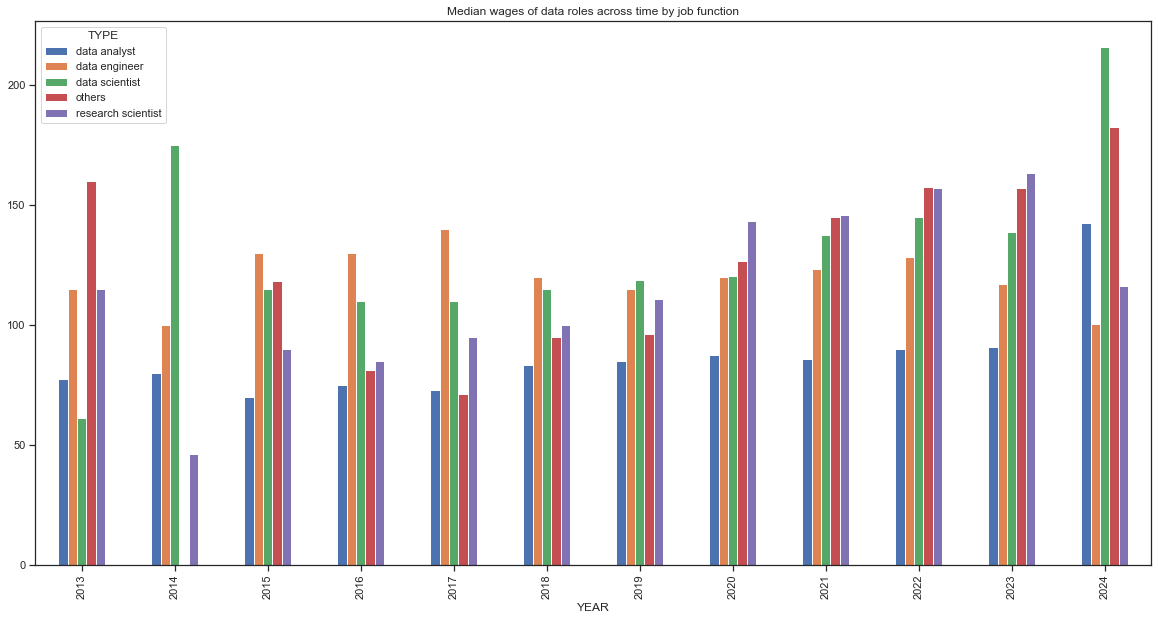

In [7]:
# get median wage of each job role for each year
df_plt = df_type_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar(figsize=(20, 10), title="Median wages of data roles across time by job function")

Generally, the median wages of all job functions have increased over time. As of 2024, data scientists have the highest median wage, followed by other functions, then data analysts, research scientists and data engineers. Compared to all other job functions, data scientists and data analysts have seen the largest increase in median wages from 2023 to 2024.

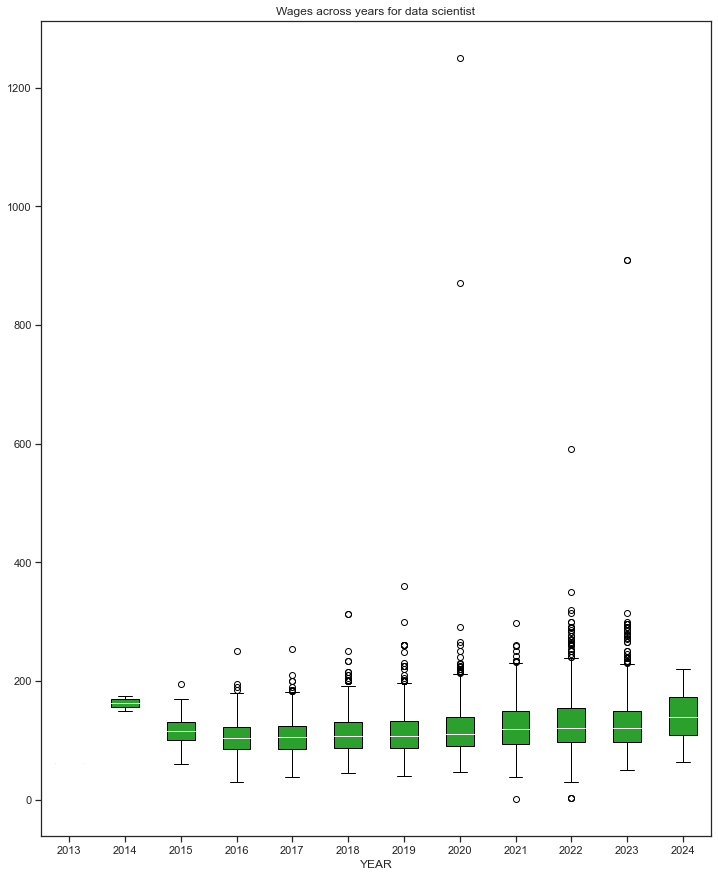

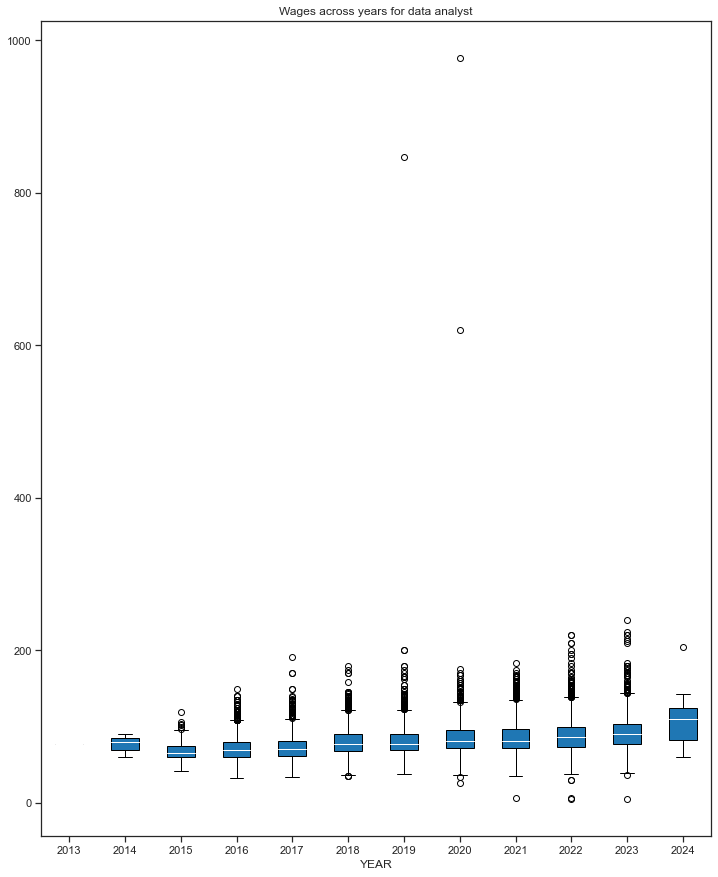

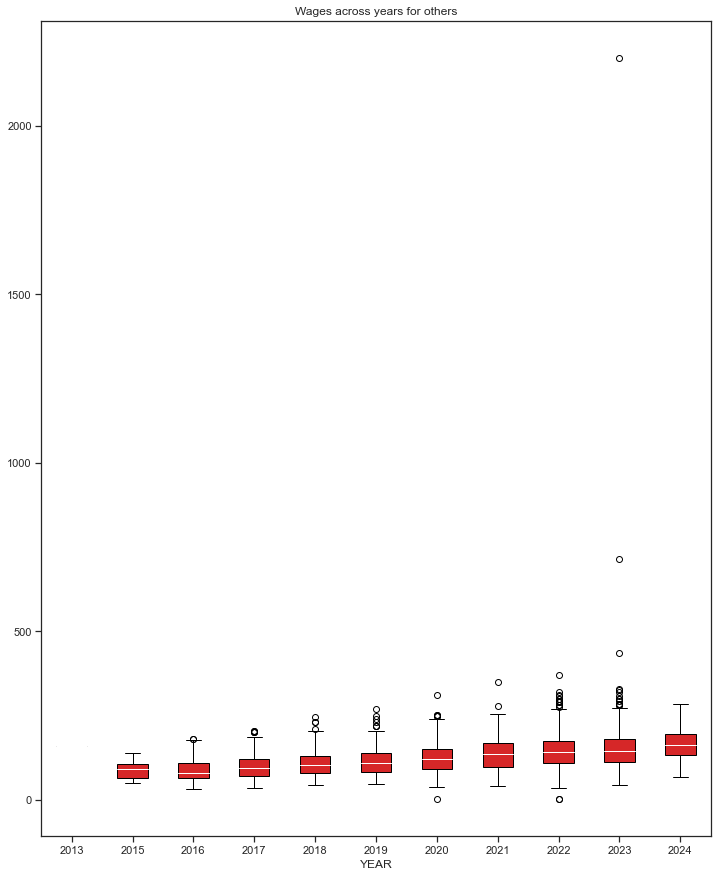

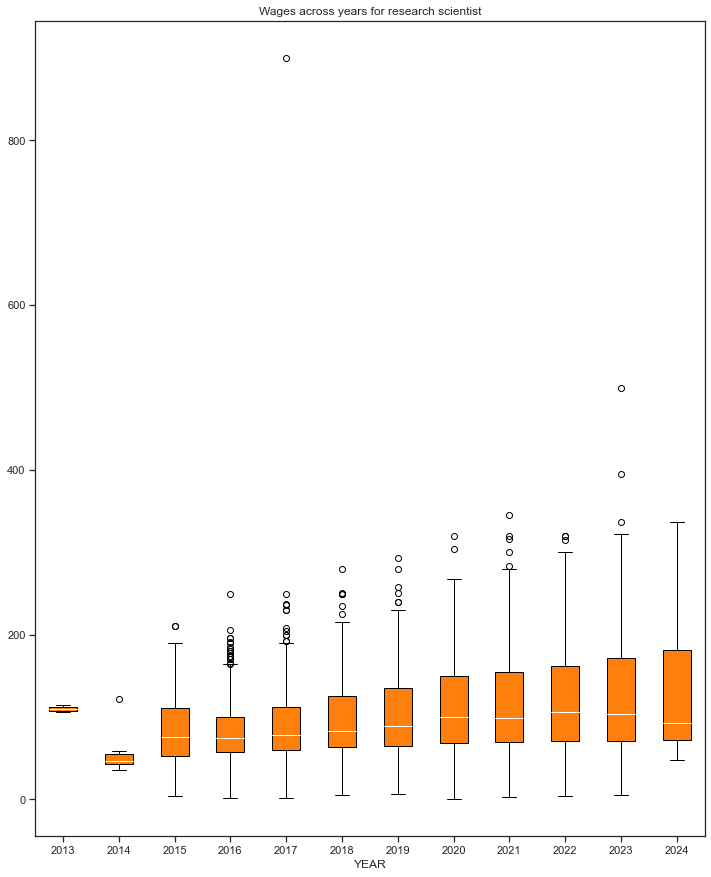

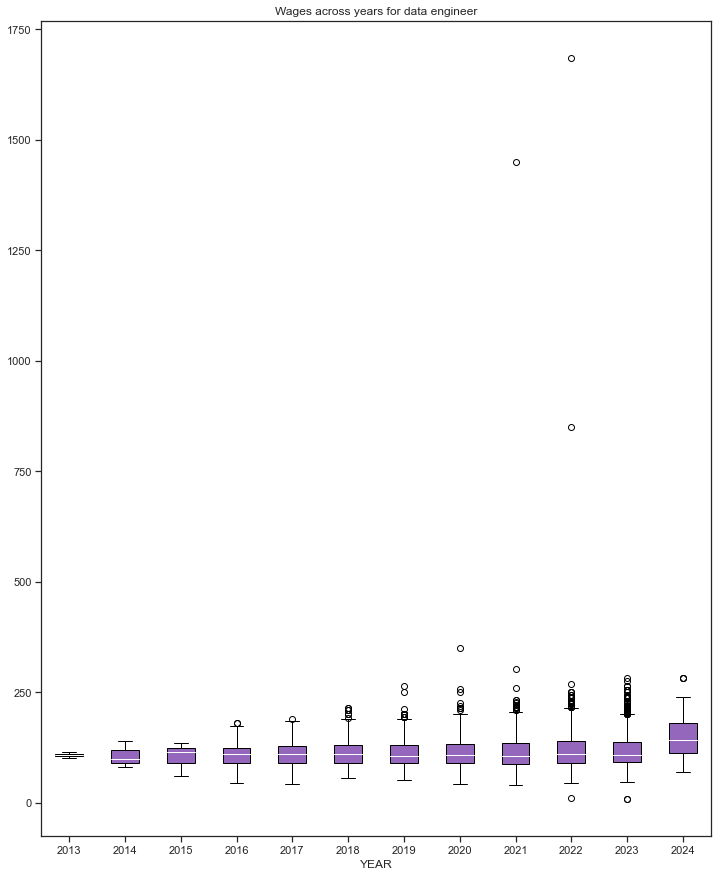

In [8]:
df_plt = df_type_agg[["YEAR", category, "y"]]

colors = ['#2ca02c','#1f77b4','#d62728','#ff7f0e','#9467bd']
for job_function, color in zip(df_plt[category].unique(), colors):
    df_filtered = df_plt[df_plt[category] == job_function]
    df_year = df_filtered.groupby('YEAR')['y'].apply(list)

    fig, ax = plt.subplots(figsize=(12, 15))
    box = ax.boxplot(df_year.values, labels=df_year.index.map(str), patch_artist=True,
                     boxprops=dict(facecolor=color),
                     medianprops=dict(color='white'))
    ax.set_title(f'Wages across years for {job_function}')
    ax.set_xlabel('YEAR')
#    ax.set_ylabel('y')
    plt.show()

For data scientists, median wages have decreased significantly since 2014 and have increased minimally since. The distribution of wages have also widened, with the wage discrepancy between the 75th and 25th percentile is the largest this year.


For data analysts, median wages have fluctuated minimally across years, except for a sudden increase in 2024. While the distribution of wages widened significantly in 2024, the lowest wage has also increased significantly compared to 2023.

For others, both the median wage and the wage distribution have generally increased over the years.

For research scientists, while median wage has fluctuated, the wage distribution has significantly widened over the years, and with positive wage outliers generally outearning more than 1.5x of the median wage. Currently in 2024, the median wage skews negative of the general wage distribution. 

For data engineers, the median wage has fluctuated over the years, and wage distribution has also increased minimally. 2024 saw the largest increase in median wage.

### 2c. Analysis of job demand by state

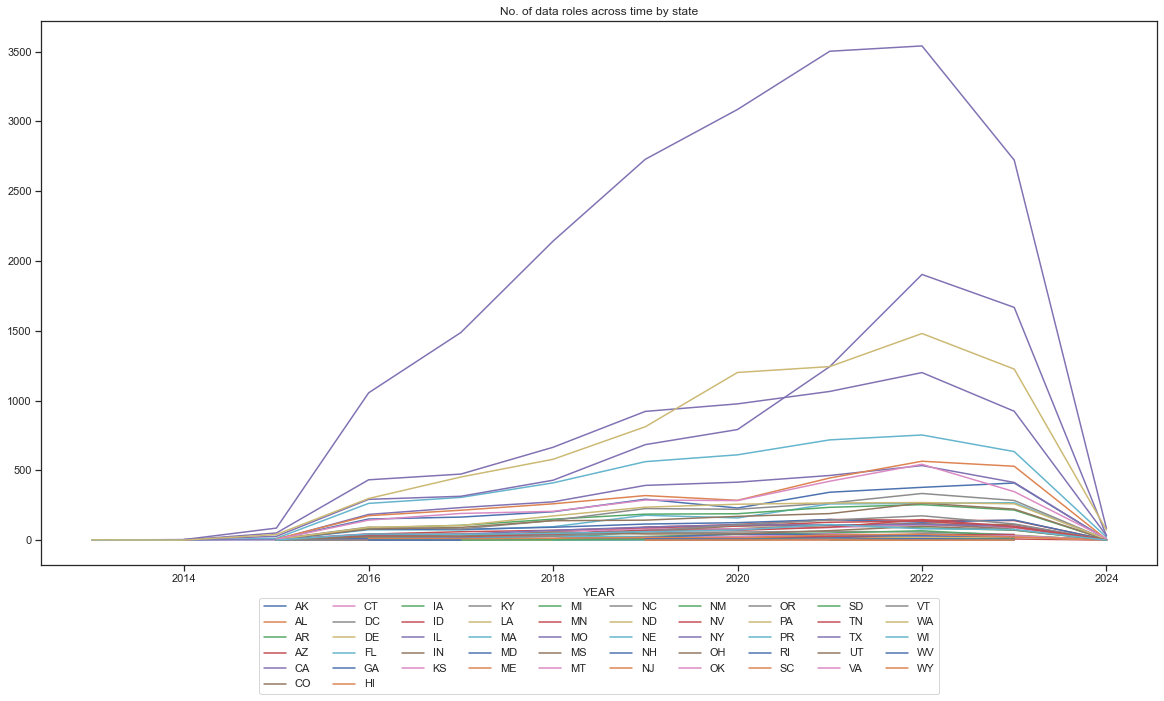

In [9]:
category = "STATE"

df_plt = all_df2[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.line(figsize=(20, 10), title="No. of data roles across time by state")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=10)

Across states, the number of data roles have been increasing across time, peaking in 2022, then decreasing in 2023. The states with the highest demand for data roles are California, Texas and New York.

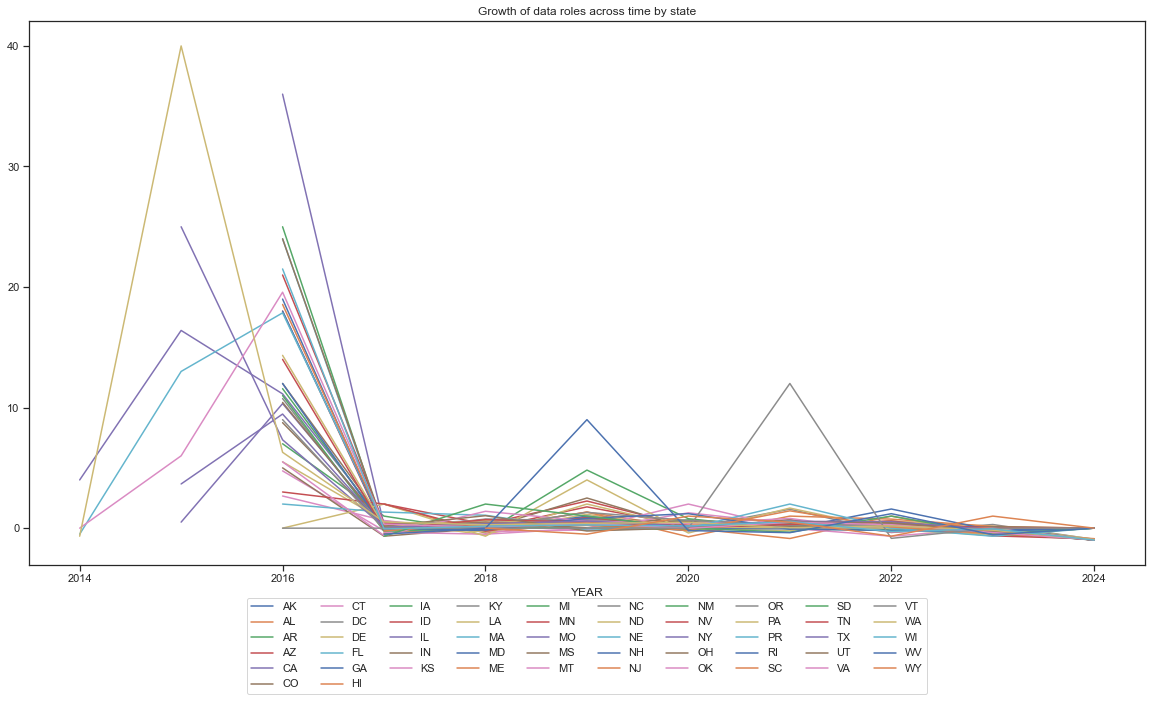

In [11]:
df_plt_growth = df_plt.loc[:, df_plt.columns!='YEAR'].pct_change() 
df_plt_growth = df_plt_growth.drop(2013)
ax = df_plt_growth.plot.line(figsize=(20, 10), title="Growth of data roles across time by state")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=10)

For YoY change in data roles, we see a drop in growth of data roles across all states in 2017, and no clear trend subsequently. However, there are also obvious spikes in growth for these roles in 2019 across some states, such as West Virginia, Arkansas and Delaware. In 2021, there is also an obvious splike in growth for Vermont.

L    71824
S     2986
Name: STATE_EMPLOYEE_SIZE, dtype: int64


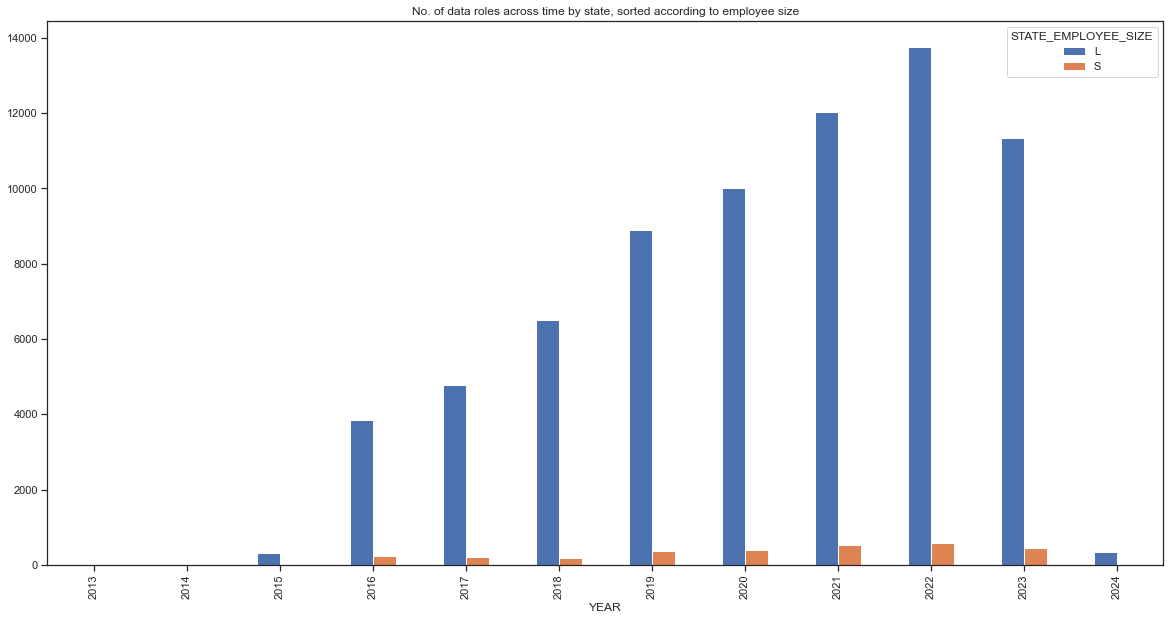

In [10]:
category = "STATE"

years = all_df2["YEAR"].unique()
df_state_agg = all_df2.copy()
df_state_agg["STATE_EMPLOYEE_SIZE"] = "L"

# get cumulative no. of hires each year
for year in years:
    df_temp = df_state_agg[df_state_agg["YEAR"] <= year].copy()
    df_temp = df_temp[[category, "y"]].groupby([category], as_index = False).size()
    median = np.quantile(df_temp["size"], 0.5)
    all_S = list(df_temp[df_temp["size"] < median]["STATE"])
    df_state_agg['STATE_EMPLOYEE_SIZE'].mask(((df_state_agg["YEAR"] == year) & (df_state_agg["STATE"].isin(all_S))),'S', inplace=True)

category = "STATE_EMPLOYEE_SIZE"

df_plt = df_state_agg[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
print(df_state_agg["STATE_EMPLOYEE_SIZE"].value_counts())
ax = df_plt.plot.bar(figsize=(20, 10), title="No. of data roles across time by state, sorted according to employee size")

By further creating variable STATE_EMPLOYEE_SIZE that classifies states as L (large) and S (small) based on its number of data employees, we can see that the number of data roles for both of these states have generally increased from 2014 to 2022, then decreased in 2023. This trend is more prominent in states with a large number of data employees.

### 2d. Analysis of wage by state

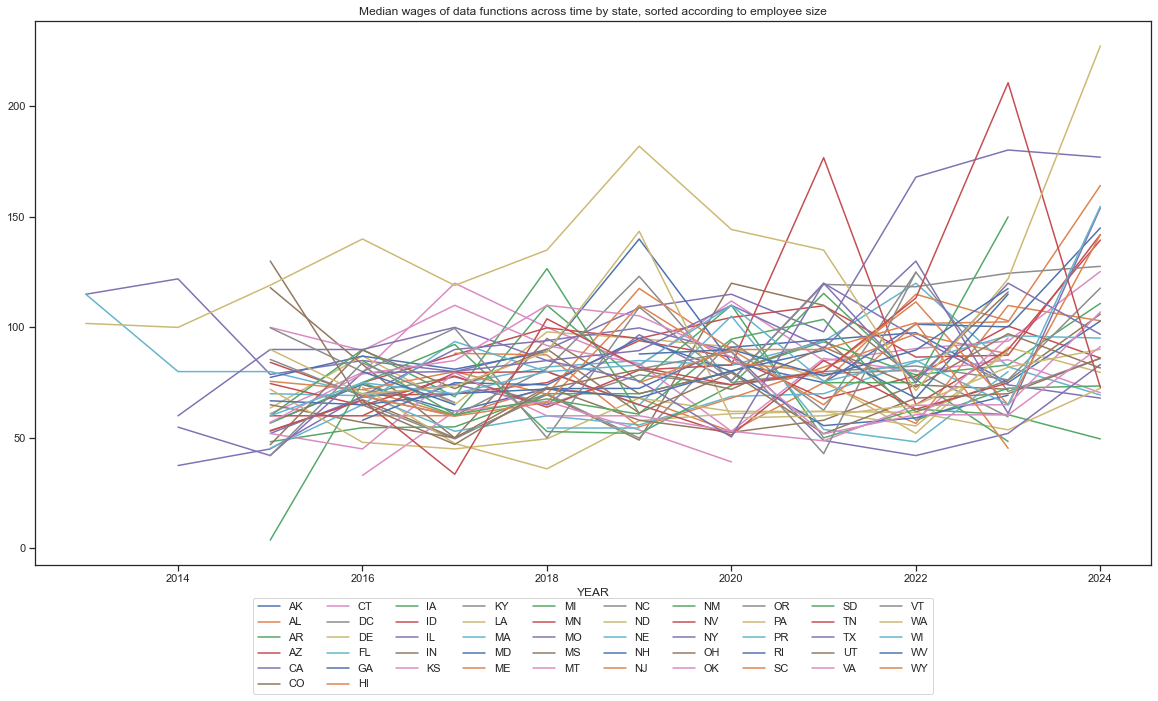

In [13]:
category = "STATE"
df_plt = all_df2[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.line(figsize=(20, 10), title="Median wages of data functions across time by state, sorted according to employee size")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=10)

From this, the median wage across states generally follow an increasing trend across time.

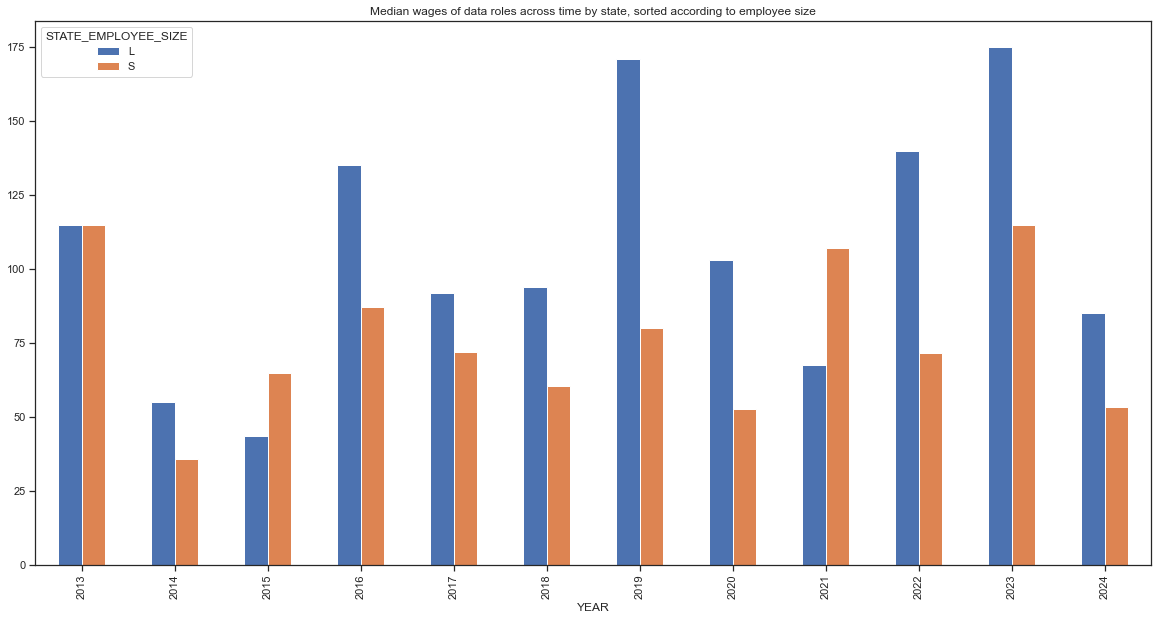

In [11]:
category = 'STATE_EMPLOYEE_SIZE'
df_plt = df_state_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar(figsize=(20, 10), title="Median wages of data roles across time by state, sorted according to employee size")

The median wages in states with a large number of data employees are generally higher than that of states with smaller numbers of data employee, with the exception of 2015 and 2023. In both of these type of states, median wages do not follow a clear trend and generally fluctuate over time. Additionally, in 2023, median wage hit an all time high in both of these type of states.

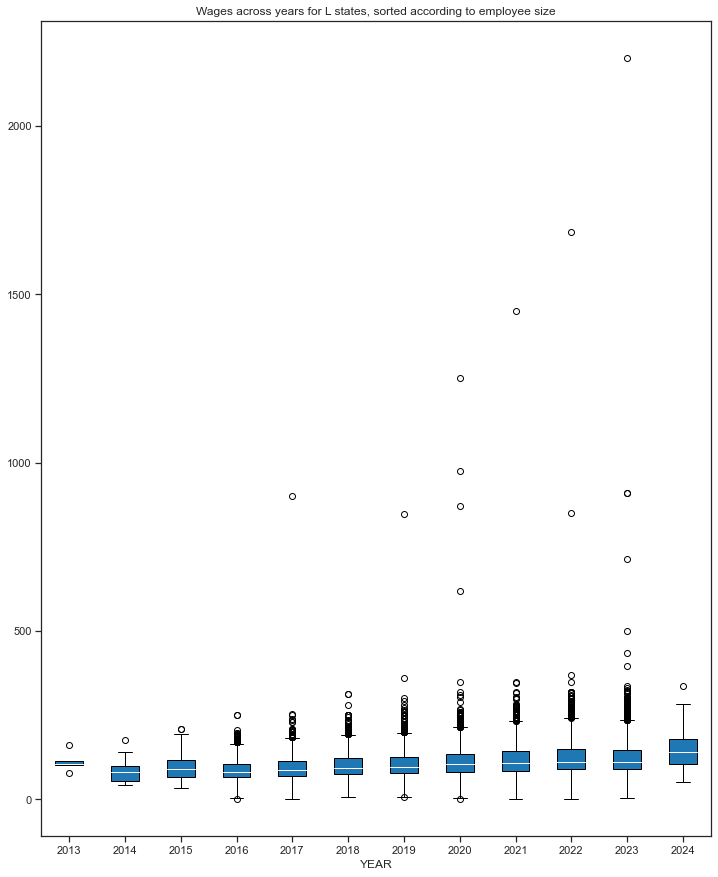

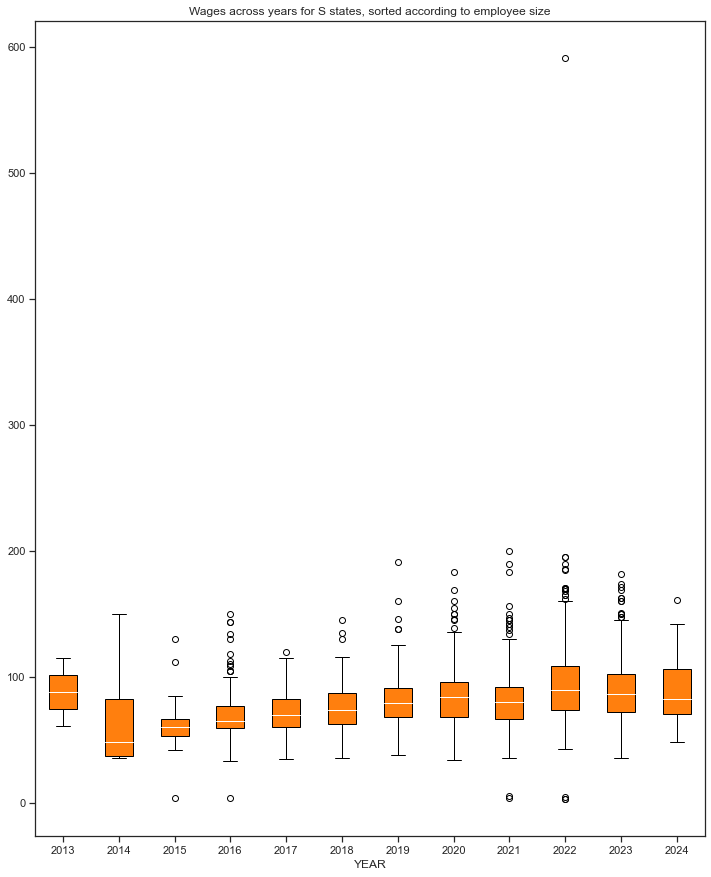

In [15]:
df_plt = df_state_agg[["YEAR", category, "y"]]

colors = ['#1f77b4','#ff7f0e']
for size, color in zip(df_plt[category].unique(), colors):
    df_filtered = df_plt[df_plt['STATE_EMPLOYEE_SIZE'] == size]
    df_year = df_filtered.groupby('YEAR')['y'].apply(list)

    fig, ax = plt.subplots(figsize=(12, 15))
    box = ax.boxplot(df_year.values, labels=df_year.index.map(str), patch_artist=True,
                     boxprops=dict(facecolor=color),
                     medianprops=dict(color='white'))
    ax.set_title(f'Wages across years for {size} states, sorted according to employee size')
    ax.set_xlabel('YEAR')
    #    ax.set_ylabel('y')
    plt.show()

For states with a large number of data employees, the median wage has generally increased slowly over the years. The wage distribution has roughly maintaine over the years, despite a large number of outliers earning significantly beyond the median wage. For states with a small number of data employees, the median wage has also generally increased along with a widening wage distribution, with exception of 2024. Currently, the wage distribution has decreased, with median wage skewing negative of the distribution.

### 2e. Analysis of job demand by employer

L    70147
S     4663
Name: EMPLOYER_SIZE, dtype: int64


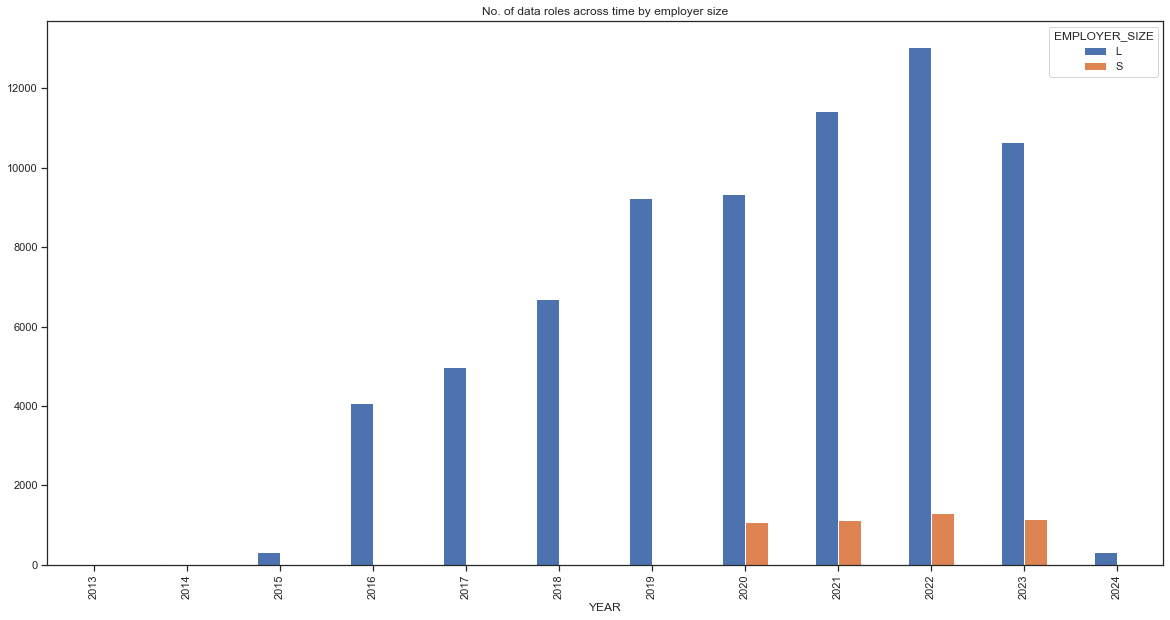

In [12]:
category = "EMPLOYER"

years = all_df2["YEAR"].unique()
df_employer_agg = all_df2.copy()
df_employer_agg["EMPLOYER_SIZE"] = "L"

# get cumulative no. of hires each year
for year in years:
    df_temp = df_employer_agg[df_employer_agg["YEAR"] <= year].copy()
    df_temp = df_temp[[category, "y"]].groupby([category], as_index = False).size()
    median = np.quantile(df_temp["size"], 0.5)
    all_S = list(df_temp[df_temp["size"] < median]["EMPLOYER"])
    df_employer_agg['EMPLOYER_SIZE'].mask(((df_employer_agg["YEAR"] == year) & (df_employer_agg["EMPLOYER"].isin(all_S))),'S', inplace=True)

category = "EMPLOYER_SIZE"

df_plt = df_employer_agg[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
print(df_employer_agg["EMPLOYER_SIZE"].value_counts())
ax = df_plt.plot.bar(figsize=(20, 10), title="No. of data roles across time by employer size")

By further creating variable EMPLOYER_SIZE that classifies employers as L (large) and S (small) based on its number of data employees, we can see that the number of data roles for both of these states have generally increased from 2014 to 2022, then decreased in 2023. This trend is more prominent in states with a large number of data employees.

### 2f. Analysis of wage by employer

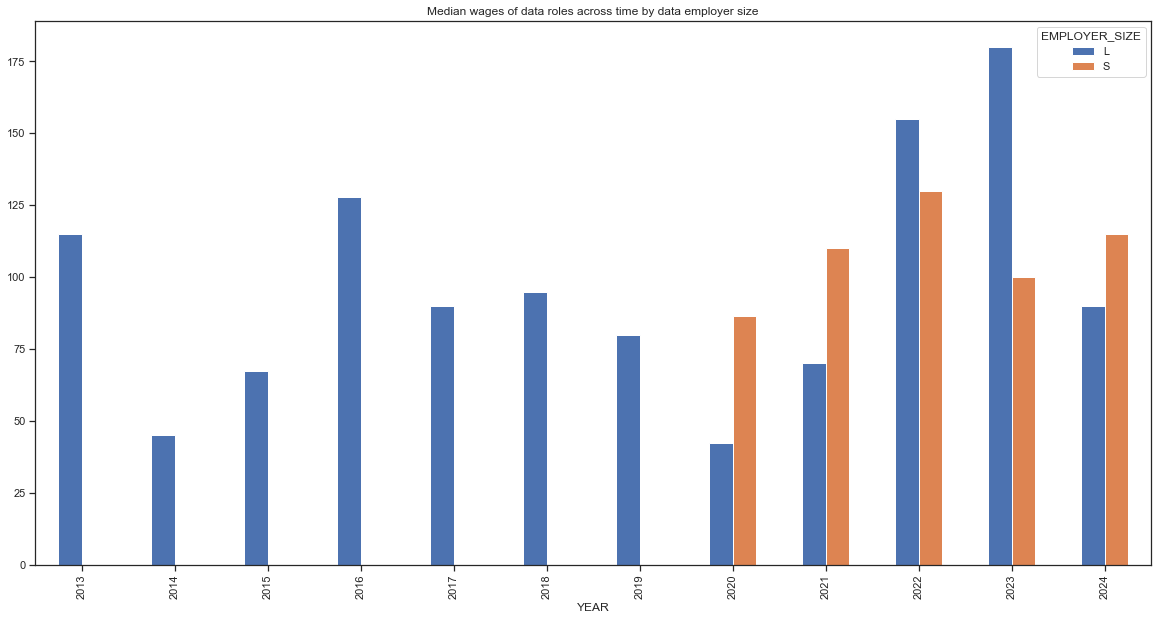

In [13]:
# get median wage of each job role for each year
df_plt = df_employer_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar(figsize=(20, 10), title="Median wages of data roles across time by data employer size")

The growth in median wages at large data employees outpaced that of small data employers, from 2021 to 2023, though not always higher when compared in absolute terms. While small data employees saw a drop in median wage in 2023, a similar drop was only observed for large data employees in 2024.

In [25]:
df_cleaned = df_type_agg.copy()
#df_cleaned["STATE_EMPLOYEE_SIZE"] = df_state_agg["STATE_EMPLOYEE_SIZE"]
df_cleaned["EMPLOYER_SIZE"] = df_employer_agg["EMPLOYER_SIZE"]

## 3. Baseline Model

In [37]:
models_performance = {}
categorical_features = ['EMPLOYER', 'JOB TITLE', 'TYPE', 'STATE']

def get_cleaned_pipeline(categories):
    clean_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(feature_names=categories)),
        ('categorical_imputer', CustomImputer(impute_type='categorical')),
        ('encoder', CustomOneHotEncoder())
    ])
    return clean_pipeline

In [16]:
X, y, X_train, X_test, y_train, y_test = get_standard_train_test_split(all_df2.dropna())

baseline_lr = Pipeline([
  ('clean_pipeline', get_cleaned_pipeline(categorical_features)),
  ('standard_scaler', StandardScaler()),
  ('lasso_regressor', Lasso(random_state=RANDOM_STATE))
])

n_scores = cross_val_score(baseline_lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
models_performance["Baseline"] = [abs(np.mean(n_scores)), np.std(n_scores)]
# report performance
print('MAE: %.3f (%.3f)' % (abs(np.mean(n_scores)), np.std(n_scores)))

MAE: 26.047 (8.110)


## With PCA

In [22]:
baseline_pca_lr = Pipeline([
    ('clean_pipeline', get_cleaned_pipeline(categorical_features)),
    ('standard_scaler', StandardScaler())
    ('pca_feature_reducer', PCA(n_components=12)),
    ('lasso_regressor', Lasso(random_state=RANDOM_STATE))
])

n_scores = cross_val_score(baseline_pca_lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
models_performance["baseline_pca_lr"] = [abs(np.mean(n_scores)), np.std(n_scores)]
# report performance
print('MAE: %.3f (%.3f)' % (abs(np.mean(n_scores)), np.std(n_scores)))

MAE: 30.872 (10.623)


# 4. Decision Tree

In [24]:
clf = DecisionTreeRegressor(criterion='friedman_mse')
#, max_depth=10, min_samples_leaf=5)
clf = clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [59]:
categorical_features = ['EMPLOYER_SIZE','TYPE', 'STATE']
X, y, X_train, X_test, y_train, y_test = get_standard_train_test_split(df_cleaned.dropna())

tree_lr = Pipeline([
    ('clean_pipeline', get_cleaned_pipeline(categorical_features)),
    ('standard_scaler', StandardScaler()),
    ('DecisionTreeRegressor', DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, min_samples_leaf=5, random_state=RANDOM_STATE))
])

n_scores = cross_val_score(tree_lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
models_performance["DecisionTreeRegressor"] = [abs(np.mean(n_scores)), np.std(n_scores)]
# report performance
print('MAE: %.3f (%.3f)' % (abs(np.mean(n_scores)), np.std(n_scores)))

MAE: 28.513 (8.700)


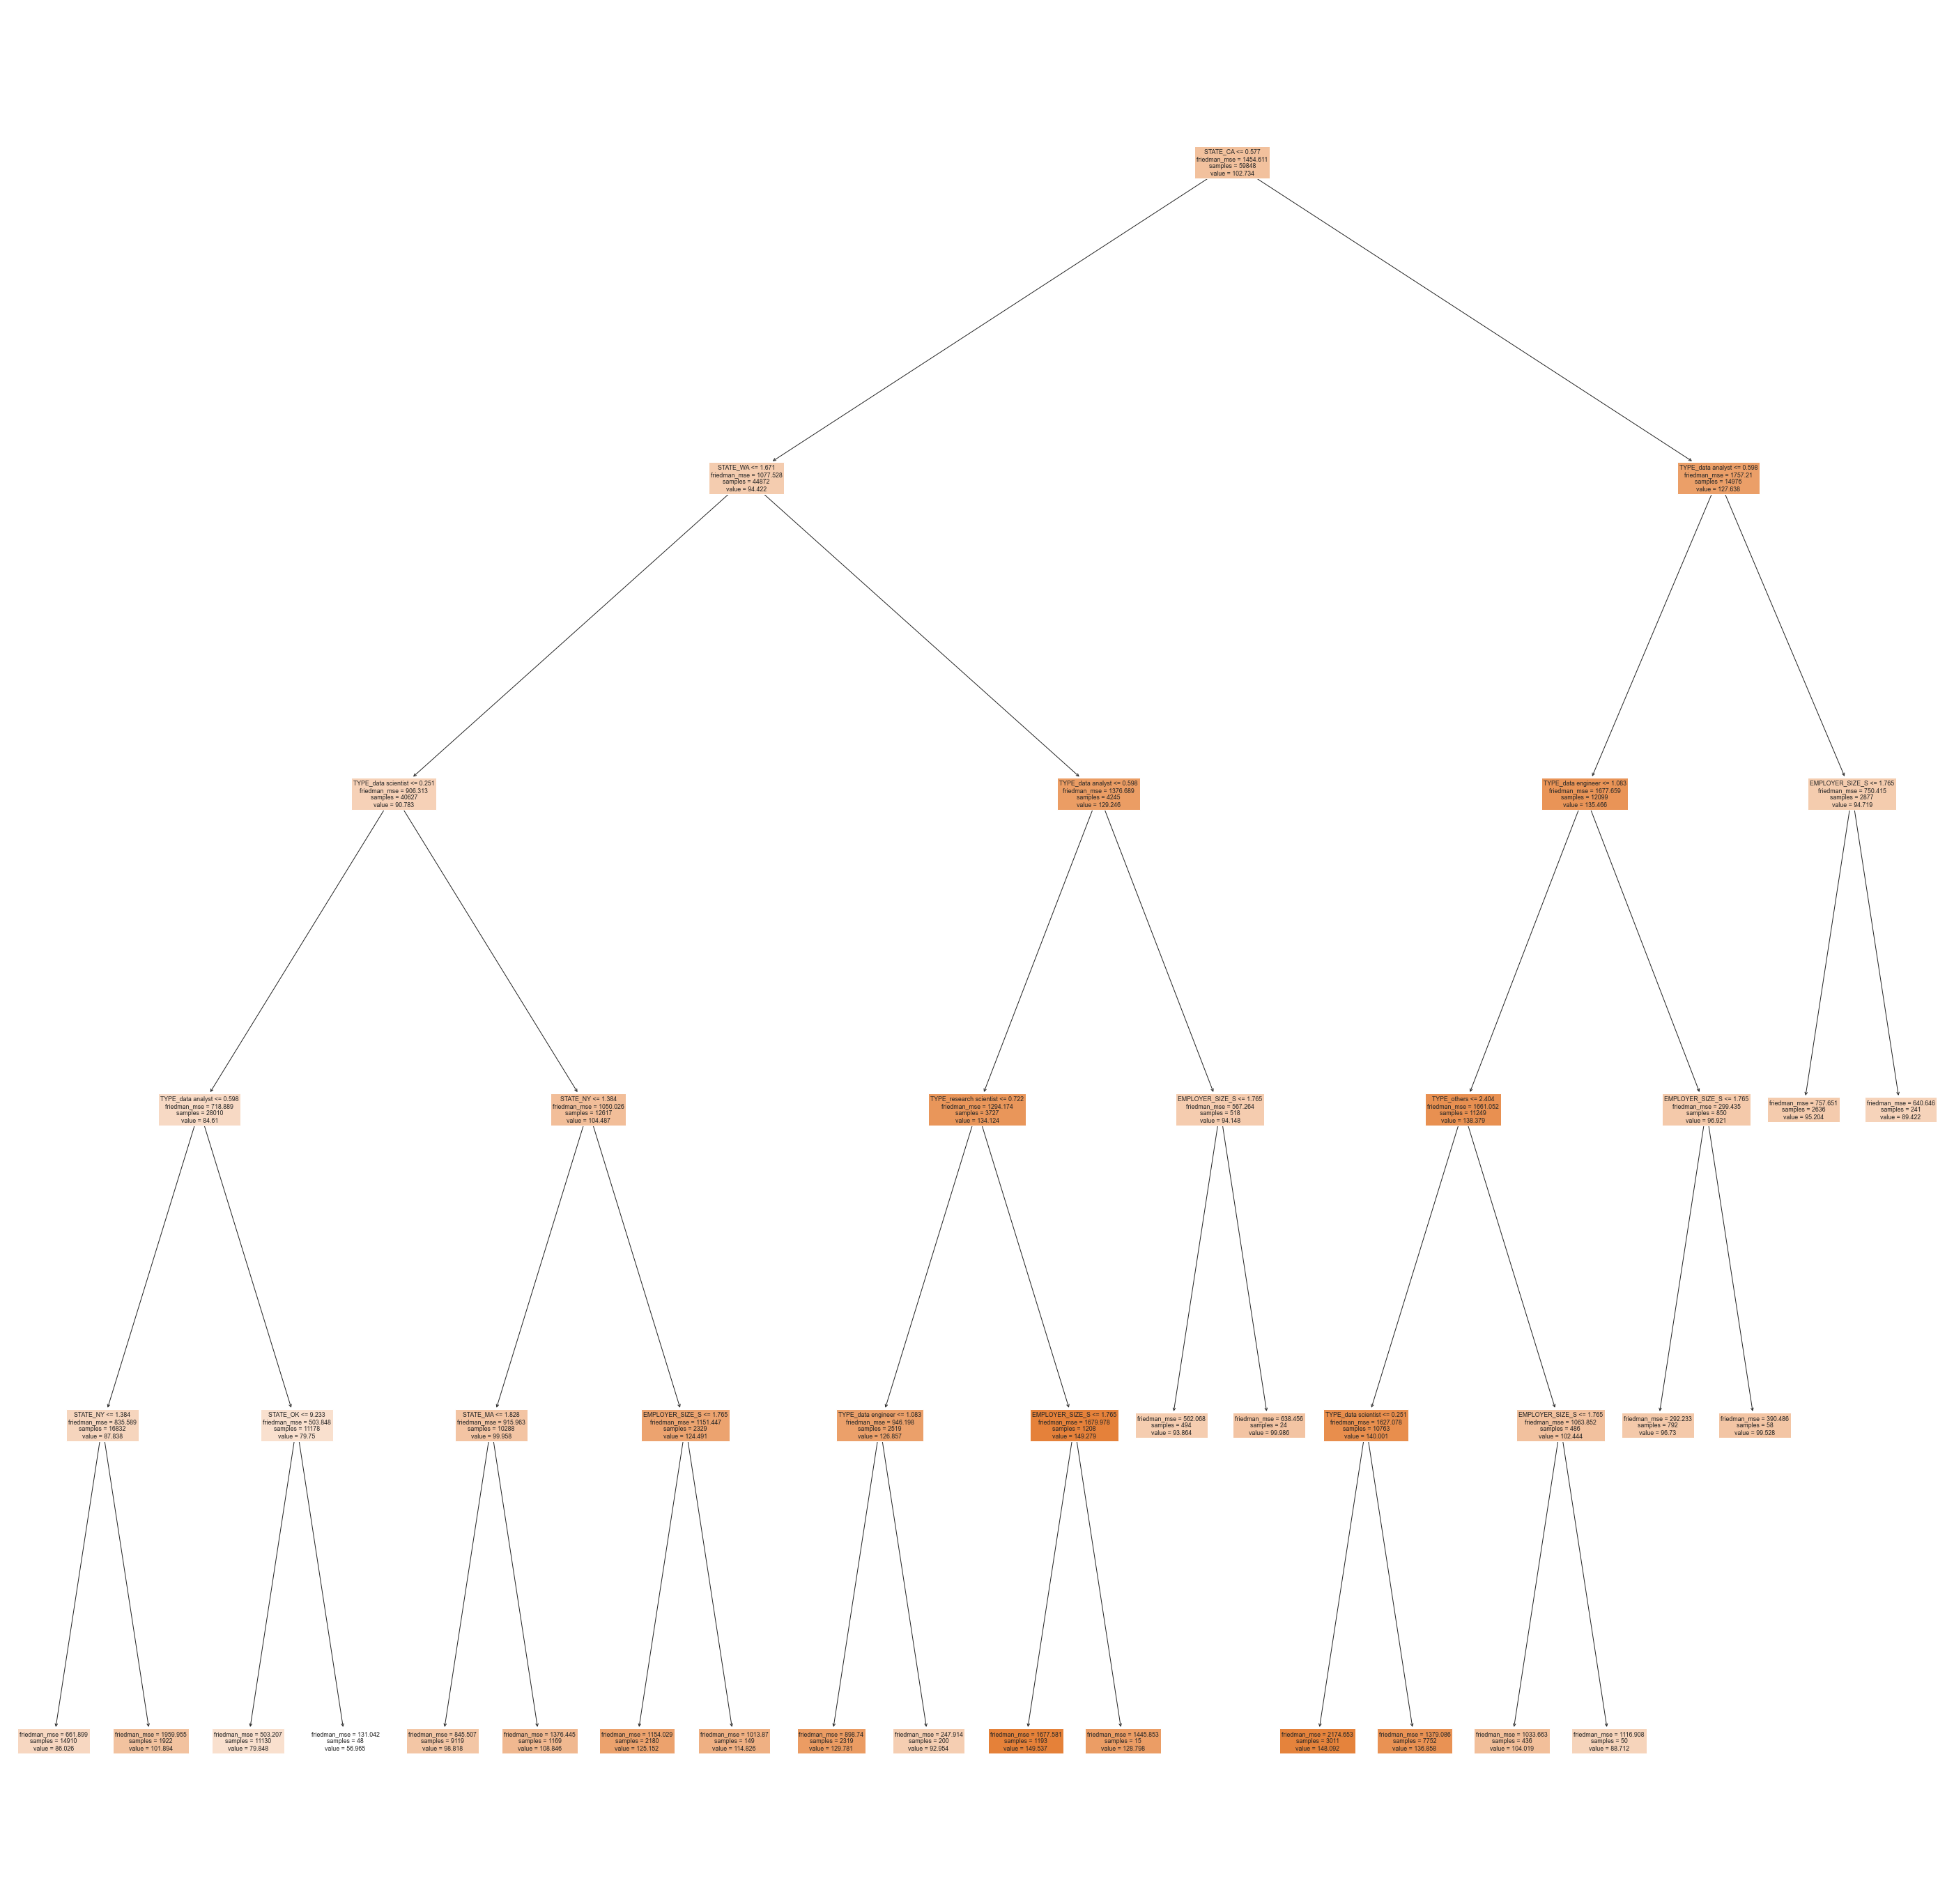

In [61]:
from sklearn import tree
tree_lr.fit(X_train, y_train)
clean_pipeline = get_cleaned_pipeline(categorical_features)
X_train_cleaned = clean_pipeline.fit_transform(X_train)
fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(tree_lr['DecisionTreeRegressor'], 
                   feature_names=X_train_cleaned.columns,  
                   class_names=['0','1'],
                   filled=True)

### Get Feature Importance

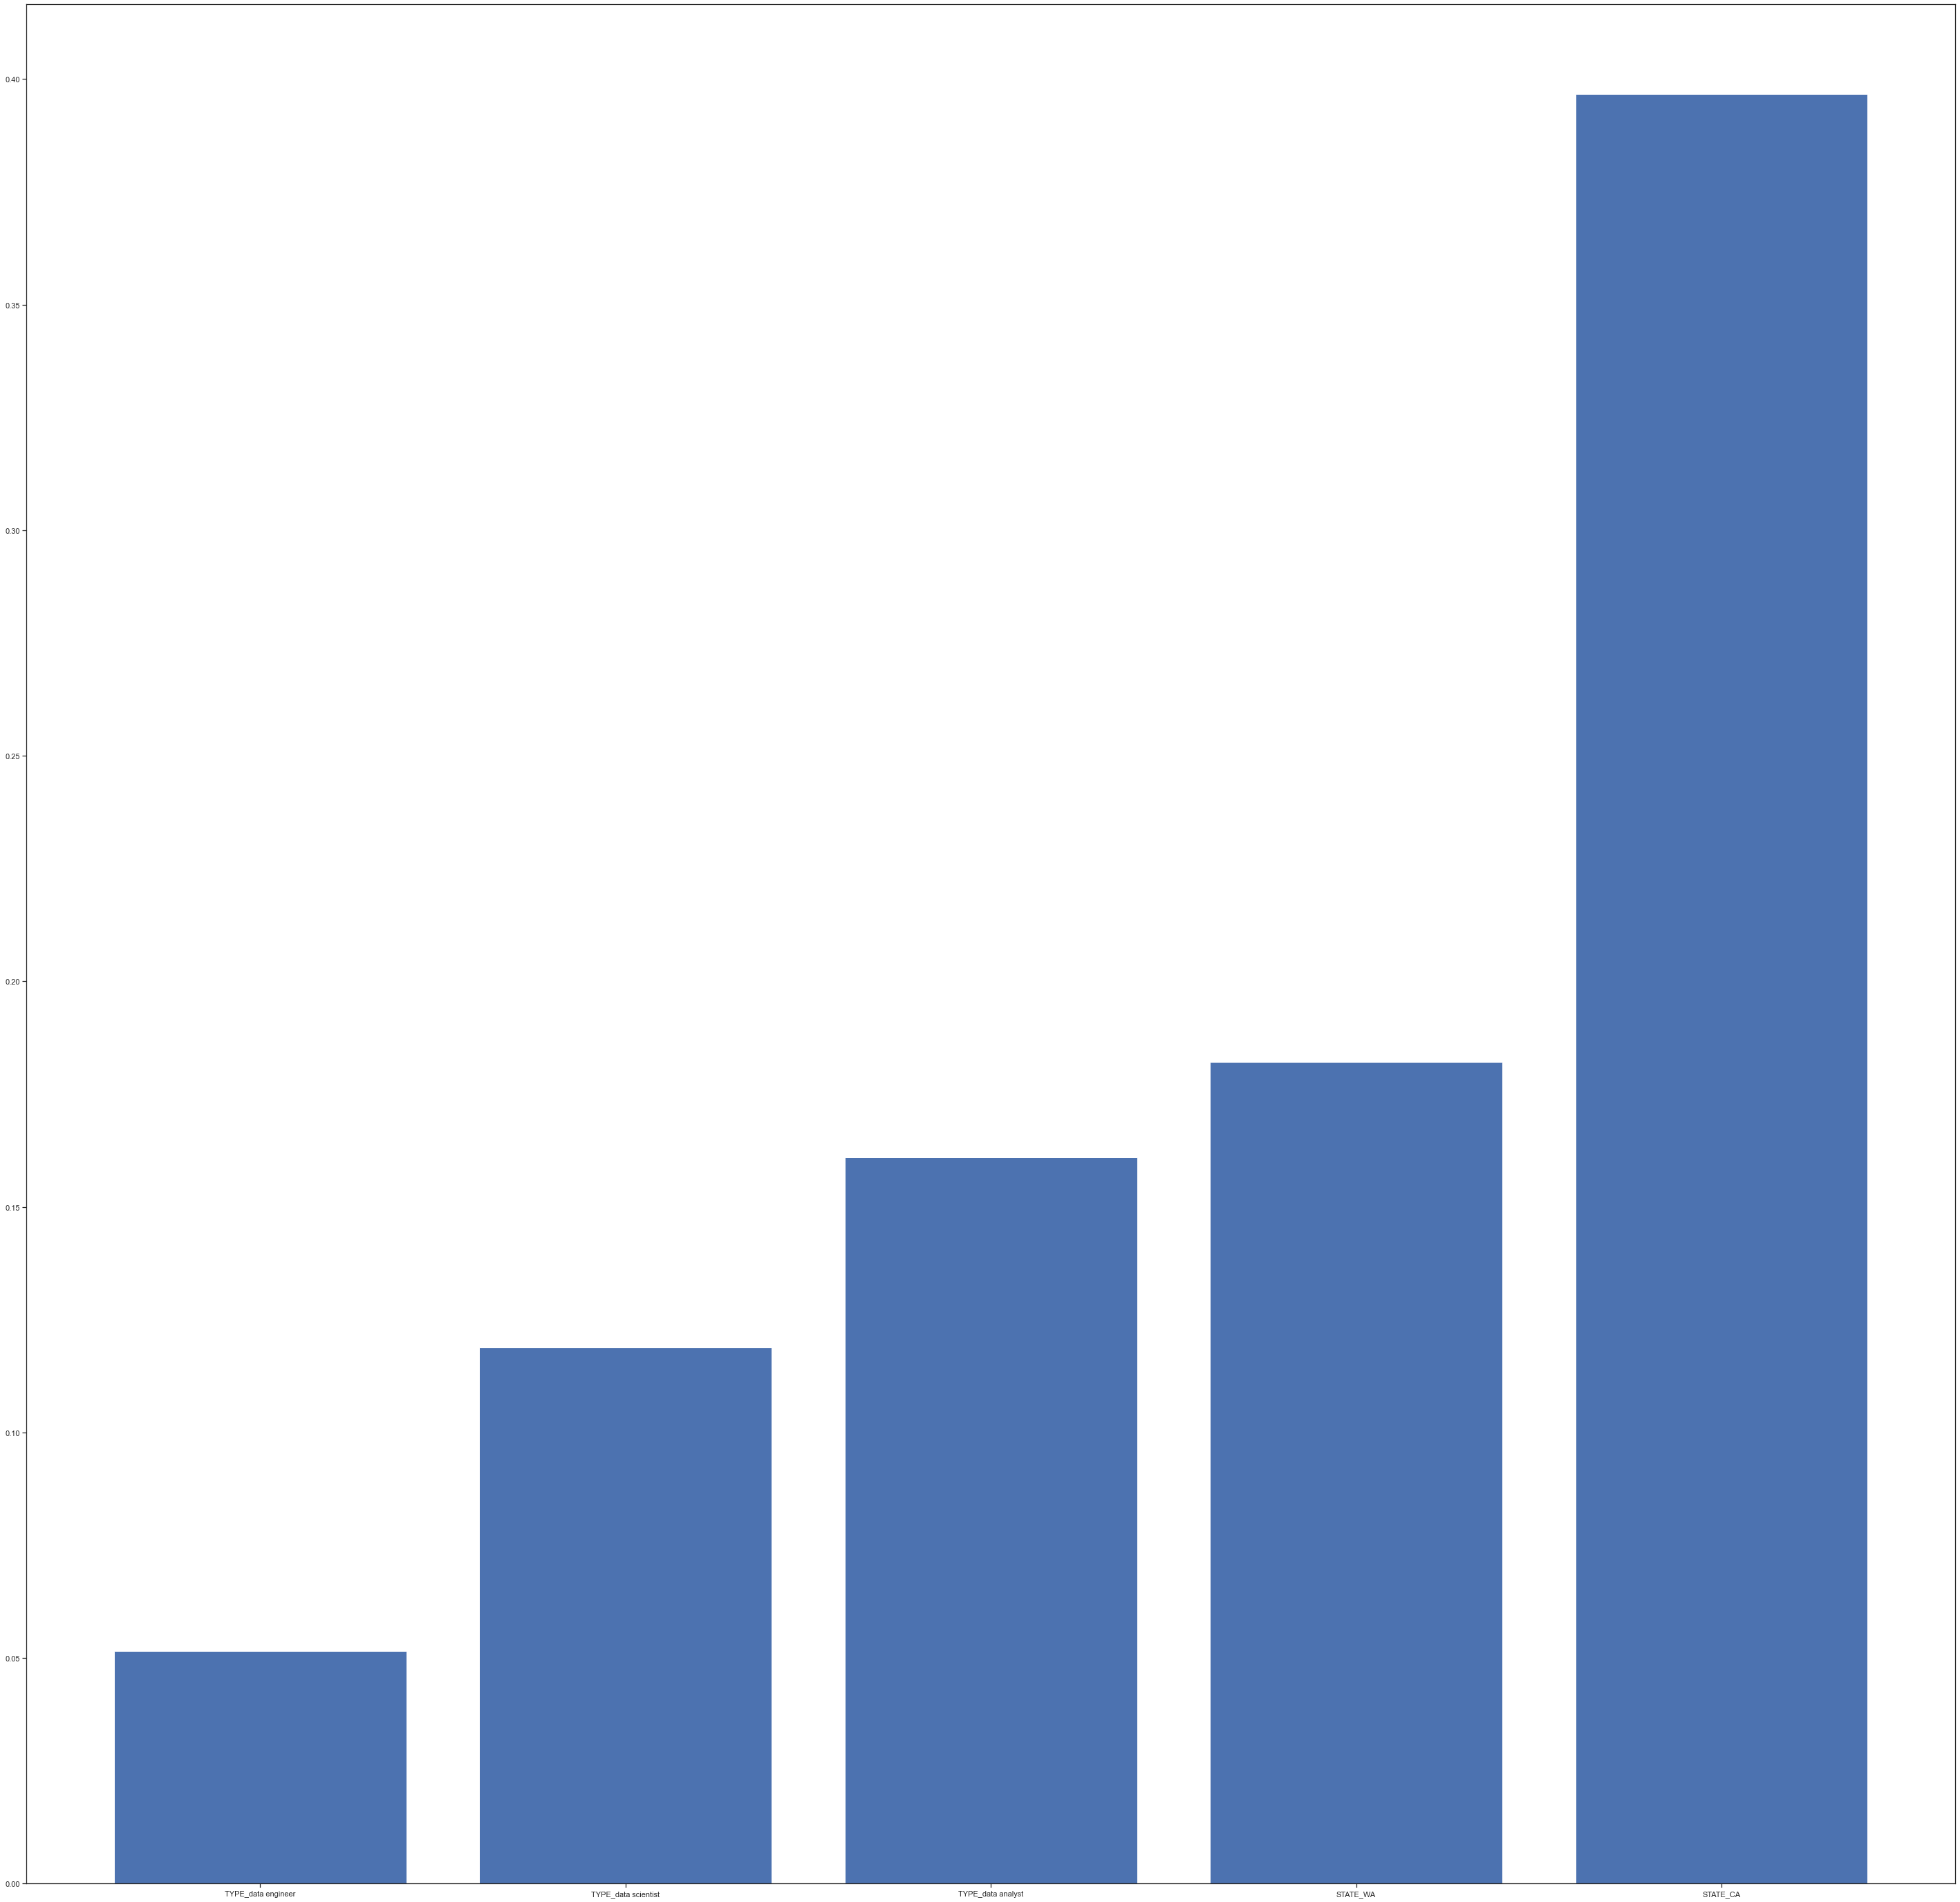

In [68]:
# get importance
importance = tree_lr['DecisionTreeRegressor'].feature_importances_
features = list(X_train_cleaned.columns)

# get index of top N important values
n = 5
indexes = sorted(range(len(importance)), key=lambda i: importance[i])[-n:]
impt_features = []
impt_features_score = []
# summarize feature importance
for i in indexes:
 impt_features.append(features[i])
 impt_features_score.append(importance[i])
# plot feature importance
plt.figure(figsize=(50,50))
plt.bar(impt_features, impt_features_score)
plt.show()
